In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

## Loading Dataset

In [2]:
data_dir = 'data\\plates\\train'

In [3]:
img_height = 256
img_width = 256

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  )

Found 40 files belonging to 2 classes.
Using 32 files for training.
Found 40 files belonging to 2 classes.
Using 8 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['cleaned', 'dirty']


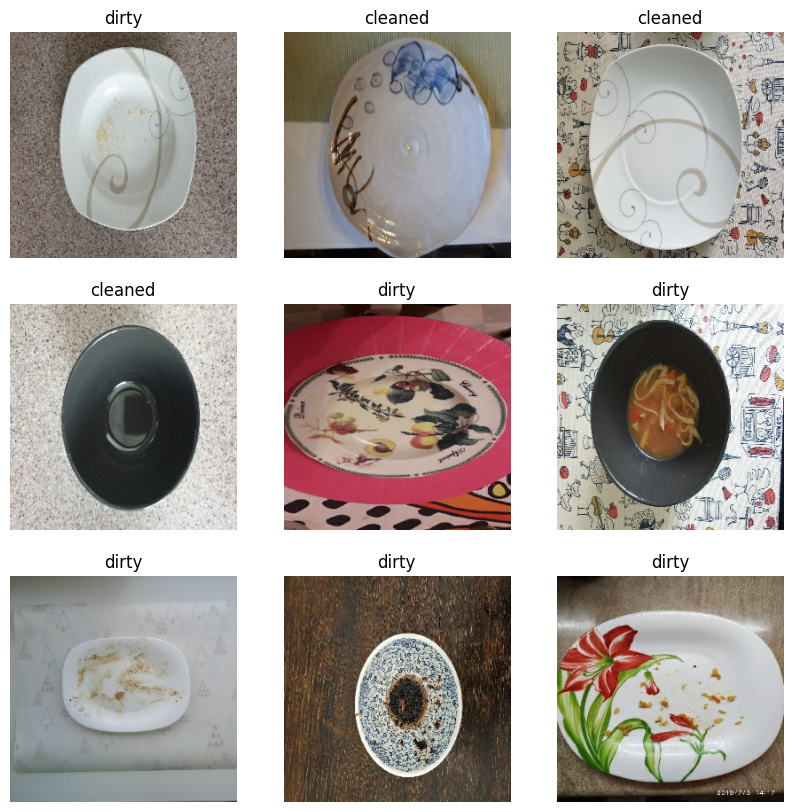

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


### Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:
- **Dataset.cache** keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- **Dataset.prefetch** overlaps data preprocessing and model execution while training.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Build Deep Learning Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomCrop, RandomTranslation, RandomHeight, RandomWidth, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense


In [24]:
model = Sequential()

# normalization layer
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# model architecture
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())

# Use GlobalAveragePooling2D instead of Flatten
model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation='relu'))
model.add(Dense(1))


In [25]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 64)       

## Model training

In [27]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

In [28]:
epochs=100

In [29]:
# Train the model
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 1.4121 - accuracy: 0.5312 - val_loss: 1.0779 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 0s 64ms/step - loss: 0.8961 - accuracy: 0.5312 - val_loss: 0.8231 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 0s 88ms/step - loss: 0.7490 - accuracy: 0.5312 - val_loss: 0.6944 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 0s 59ms/step - loss: 0.7056 - accuracy: 0.5625 - val_loss: 0.6506 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 0s 101ms/step - loss: 0.7388 - accuracy: 0.5000 - val_loss: 0.6555 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 0s 63ms/step - loss: 0.7791 - accuracy: 0.4688 - val_loss: 0.6537 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - 0s 63ms/step - loss: 0.7647 - ac

## Plot Performance

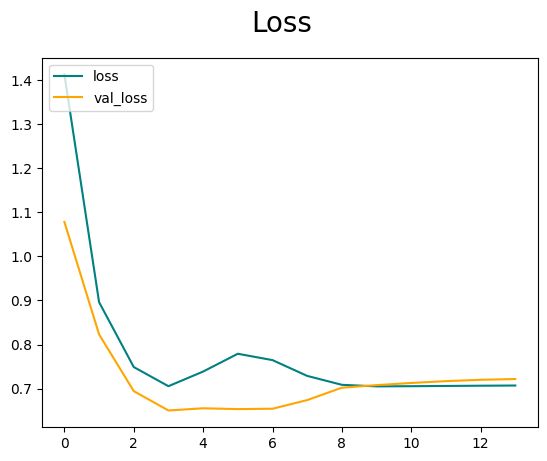

In [31]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

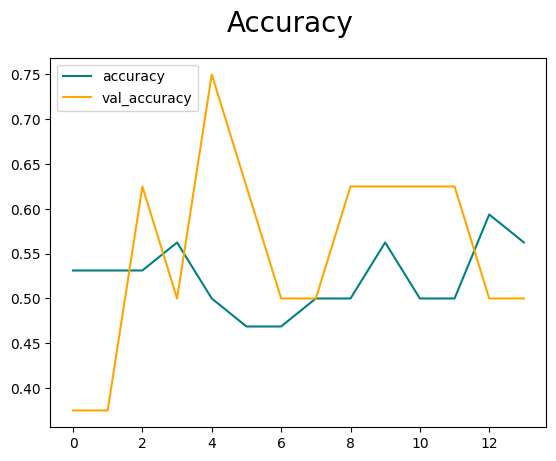

In [32]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Creating Submission

In [46]:
test_dir = 'data\\plates\\test'

In [47]:
# file names in the test directory
import os
test_files = os.listdir(test_dir)
print(test_files)

['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg', '0006.jpg', '0007.jpg', '0008.jpg', '0009.jpg', '0010.jpg', '0011.jpg', '0012.jpg', '0013.jpg', '0014.jpg', '0015.jpg', '0016.jpg', '0017.jpg', '0018.jpg', '0019.jpg', '0020.jpg', '0021.jpg', '0022.jpg', '0023.jpg', '0024.jpg', '0025.jpg', '0026.jpg', '0027.jpg', '0028.jpg', '0029.jpg', '0030.jpg', '0031.jpg', '0032.jpg', '0033.jpg', '0034.jpg', '0035.jpg', '0036.jpg', '0037.jpg', '0038.jpg', '0039.jpg', '0040.jpg', '0041.jpg', '0042.jpg', '0043.jpg', '0044.jpg', '0045.jpg', '0046.jpg', '0047.jpg', '0048.jpg', '0049.jpg', '0050.jpg', '0051.jpg', '0052.jpg', '0053.jpg', '0054.jpg', '0055.jpg', '0056.jpg', '0057.jpg', '0058.jpg', '0059.jpg', '0060.jpg', '0061.jpg', '0062.jpg', '0063.jpg', '0064.jpg', '0065.jpg', '0066.jpg', '0067.jpg', '0068.jpg', '0069.jpg', '0070.jpg', '0071.jpg', '0072.jpg', '0073.jpg', '0074.jpg', '0075.jpg', '0076.jpg', '0077.jpg', '0078.jpg', '0079.jpg', '0080.jpg', '0081.jpg', '0082.jpg', '00

In [49]:
# file formats in the test directory
test_formats = [f.split('.')[-1] for f in test_files]
print(np.unique(test_formats))

['jpg']


In [52]:
# Load the test data without expecting labels
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    labels='inferred',  # Set to 'inferred' since we don't have labels
    label_mode=None,  # No labels, so set mode to None
    color_mode='rgb',  # Assuming RGB images
    shuffle=False  # No need to shuffle test data
)

Found 744 files belonging to 1 classes.


In [53]:
# Predict the test data
predictions = model.predict(test_ds)
print(predictions)

19/19 [==============================] - 1s 34ms/step
[[0.4182915 ]
 [0.33350033]
 [0.3637507 ]
 [0.3659541 ]
 [0.39452952]
 [0.39712378]
 [0.40869126]
 [0.3502968 ]
 [0.37215465]
 [0.4203996 ]
 [0.36957347]
 [0.39817354]
 [0.32227865]
 [0.3694226 ]
 [0.39881685]
 [0.50330657]
 [0.47581682]
 [0.49764118]
 [0.31939217]
 [0.43760037]
 [0.36983714]
 [0.37620518]
 [0.4628452 ]
 [0.4138177 ]
 [0.43271777]
 [0.38352764]
 [0.33331764]
 [0.42293772]
 [0.51109165]
 [0.36195117]
 [0.40682587]
 [0.45351863]
 [0.393608  ]
 [0.35543618]
 [0.36553752]
 [0.3532297 ]
 [0.46165827]
 [0.4229239 ]
 [0.36324298]
 [0.3617455 ]
 [0.32637662]
 [0.36640564]
 [0.34064263]
 [0.35416558]
 [0.3847977 ]
 [0.38139635]
 [0.37567863]
 [0.4152331 ]
 [0.39756846]
 [0.38240117]
 [0.33915487]
 [0.3503798 ]
 [0.4446481 ]
 [0.3990578 ]
 [0.31261182]
 [0.3123461 ]
 [0.3671269 ]
 [0.36745536]
 [0.30963096]
 [0.45312726]
 [0.3857015 ]
 [0.34027365]
 [0.41689092]
 [0.34996852]
 [0.3581681 ]
 [0.36196783]
 [0.2455498 ]
 [0.3759

In [56]:
# Get the predicted class: 0 or 1
predicted_classes = (predictions > 0.5).astype("int32") # Convert boolean to 0 or 1
predicted_classes = predicted_classes.flatten() # Flatten to get a 1D array
print(predicted_classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [70]:
# create a dataframe with filenames and predictions
df = pd.DataFrame({
    'id': [x.split('.')[0] for x in test_files],
    'label': ['clean' if p == 1 else 'dirty' for p in predicted_classes]
})
df.head()

,id,label
0,0000,dirty
1,0001,dirty
2,0002,dirty
3,0003,dirty
4,0004,dirty


In [72]:
df.to_csv('predictions.csv', index=False)

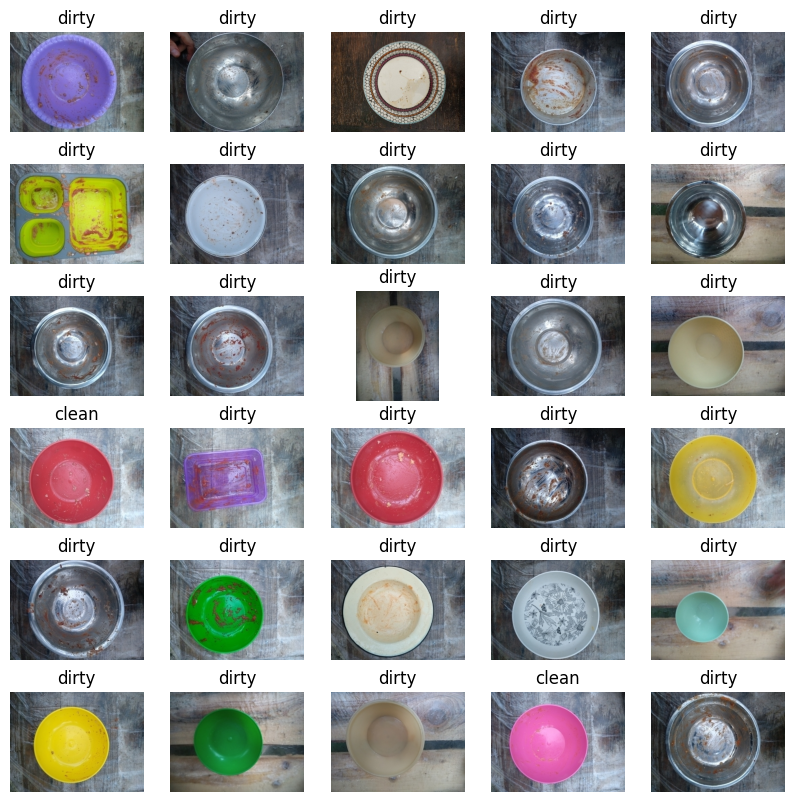

In [77]:
# plot 30 predictions images and their labels
plt.figure(figsize=(10, 10))
for i in range(30):
    ax = plt.subplot(6, 5, i + 1)
    plt.imshow(tf.keras.preprocessing.image.load_img(
        os.path.join(test_dir, test_files[i])
    ))
    plt.title(df['label'][i])
    plt.axis("off")
plt.show()
